# Guardians of the Memory - XGBoost - Felix

Baseline model for the HHD classification problem. The task is to classify if a certain HDD will fail in the next x days (in the following we try to predict HDD failure two weeks in advance).

As a metric, we look at the area under the ROC curve while we monitor the recall. We want to minimize false negatives (predicting that a HDD will not fail, but it fails nevertheless) as this might lead to data loss and maintenance downtime.

The dataset we use contains only the one model that failed the most recently (Seagate ST4000DM000) and only drives where we observed the failing in the dataset (2020 untill 2021). We use all available dates for those drives.

For the baseline model, we focus on the four most important features that we observed in the EDA: `smart_5_raw`, `smart_183_raw`, `smart_184_raw` and `smart_187_raw`. We calculate the median of those features a certain number of days before the drives fail use this value as threshold. If two (out of the four) of the features of a drive are above the threshold, we predict that the drive will fail in the given time window.

Import Libraries

In [20]:
import os
import sys
sys.path.append("..")

from src.data.preprocessing import load_preprocess_data

import pandas as pd
import numpy as np
import mlflow
# Setup MLFlow
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, fbeta_score

RSEED = 42

import warnings
warnings.filterwarnings(action='once')

## Preprocessing

Load the data

In [2]:
repo_path = os.getcwd()+"/../"
df = load_preprocess_data(path=repo_path)
df.shape

(462966, 42)

## Feature Engineering

In [3]:
feats_bl = ["smart_5_raw",
            "smart_183_raw",
            "smart_184_raw",
            "smart_187_raw",
            ]

df[feats_bl].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,462966.0,126.252813,1918.915422,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,462966.0,3.838230,29.389742,0.0,0.0,0.0,2.0,720.0
smart_184_raw,462966.0,0.148525,4.021683,0.0,0.0,0.0,0.0,340.0
smart_187_raw,462966.0,5.123342,25.932870,0.0,0.0,0.0,0.0,940.0


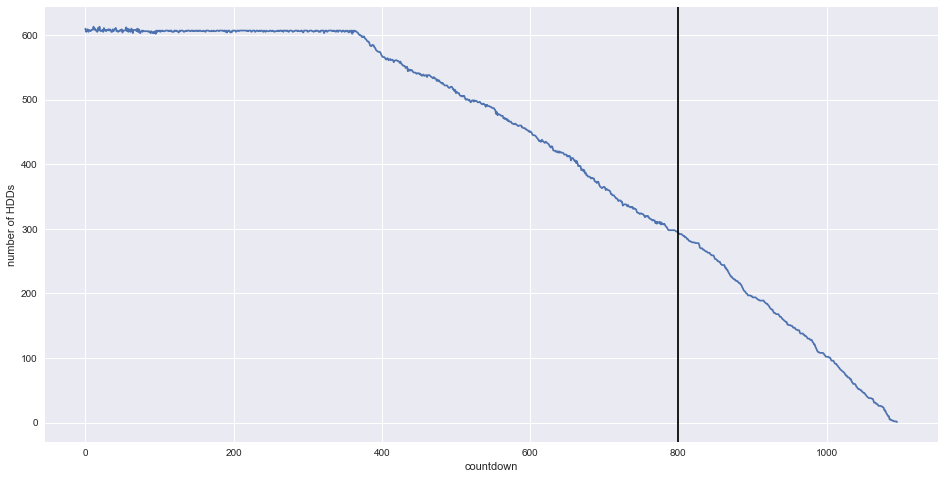

In [4]:
plt.figure(figsize=(16,8))
# sns.lineplot(x=df.groupby("countdown").count().index, y=df.groupby("countdown").count().date)
sns.lineplot(data=df.groupby("countdown").count().date)
plt.axvline(x=800, c='k')
plt.ylabel("number of HDDs");

(418172, 42)


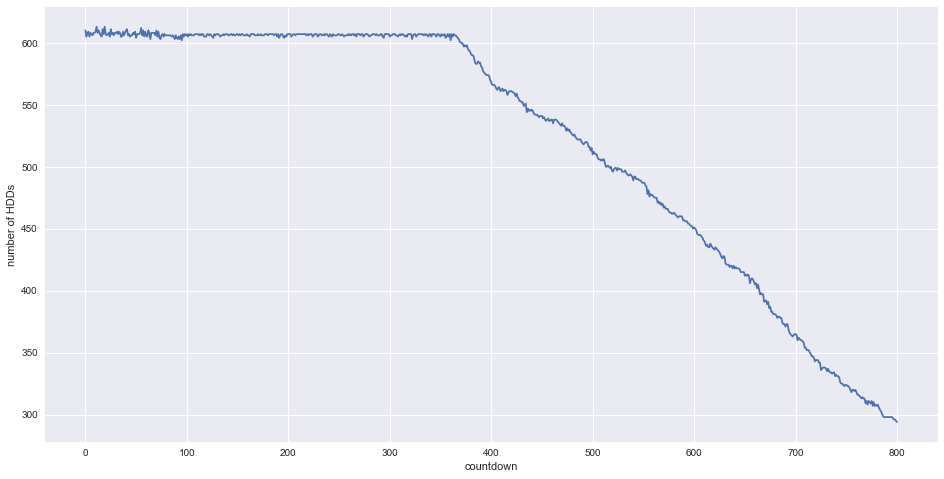

In [5]:
df = df[df.countdown <= 800]
print(df.shape)
plt.figure(figsize=(16,8))
# sns.lineplot(x=df.groupby("countdown").count().index, y=df.groupby("countdown").count().date)
sns.lineplot(data=df.groupby("countdown").count().date)
plt.ylabel("number of HDDs");

## XGBoost

### Train-test split

We have to split by drive serial numbers (all time data for one drive stays in one set). This cannot be done by stratify, so we write our own function.

In [6]:
drives = pd.Series(df.serial_number.unique(), name="HDD") # All the unique serial numbers
test_size = 0.3
time_window = 30
drives_test = drives.sample(int(test_size * len(drives)), random_state=RSEED) # Random sampling of drives
drives_train = drives.drop(drives_test.index, axis=0) # Remaining drives end up in the train set
df_train = df[df.serial_number.isin(drives_train)]
df_test = df[df.serial_number.isin(drives_test)]

Generate dataframes from the drive lists

In [7]:
X_train = df_train[feats_bl]
X_test = df_test[feats_bl]
print("Shape train set:", X_train.shape, "\nShape test set:", X_test.shape)

Shape train set: (291914, 4) 
Shape test set: (126258, 4)


Generate targets: `True` if `countdown` is smaller than our time window, `False` otherwise.

In [8]:
y_train = df_train.countdown <= time_window
y_test = df_test.countdown <= time_window

Now we check if our sampling is stratified:

In [9]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.04523935131579849, 0.044662516434602166)

I would say it looks ok. Perhaps stratify can be included later.

Now lets setup MLFlow:

In [10]:
# # setting the MLFlow connection and experiment
# mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)
# mlflow.start_run()
# run = mlflow.active_run()
# print("Active run_id: {}".format(run.info.run_id))

### Train the model and calculate metrics

In [11]:
model_pipe = Pipeline([
    # ('attr_addr', features_pipeline),
    #('preprocessor', preprocessor),
    ('xgb', XGBClassifier(eval_metric="auc", scale_pos_weight=len(y_train)/y_train.sum()))
])

# Defining parameter grid (as dictionary)
param_grid = {'xgb__n_estimators': list(range(100,1000,50)),
              'xgb__learning_rate': list(np.linspace(0.001, 0.5, 100)),
              'xgb__max_depth': list(range(1, 50))
    }
# Instantiate gridsearch and define the metric to optimize 
gs = RandomizedSearchCV(model_pipe,  param_grid, scoring='roc_auc',
                  cv=5, verbose=2, n_jobs=-1, n_iter=5)

# Fit gridsearch object to data.
gs.fit(X_train, y_train)

y_pred = gs.predict(X_test)
y_pred_train = gs.predict(X_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: F

[CV 5/5] END xgb__learning_rate=0.046363636363636364, xgb__max_depth=35, xgb__n_estimators=600;, score=0.731 total time= 6.3min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 1/5] END xgb__learning_rate=0.046363636363636364, xgb__max_depth=35, xgb__n_estimators=600;, score=0.677 total time= 6.4min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END xgb__learning_rate=0.046363636363636364, xgb__max_depth=35, xgb__n_estimators=600;, score=0.635 total time= 6.4min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 2/5] END xgb__learning_rate=0.046363636363636364, xgb__max_depth=35, xgb__n_estimators=600;, score=0.699 total time= 6.5min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END xgb__learning_rate=0.046363636363636364, xgb__max_depth=35, xgb__n_estimators=600;, score=0.658 total time= 6.5min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END xgb__learning_rate=0.021161616161616163, xgb__max_depth=28, xgb__n_estimators=800;, score=0.675 total time= 6.7min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 3/5] END xgb__learning_rate=0.021161616161616163, xgb__max_depth=28, xgb__n_estimators=800;, score=0.659 total time= 6.9min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END xgb__learning_rate=0.021161616161616163, xgb__max_depth=28, xgb__n_estimators=800;, score=0.700 total time= 7.0min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 5/5] END xgb__learning_rate=0.021161616161616163, xgb__max_depth=28, xgb__n_estimators=800;, score=0.728 total time= 6.9min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 4/5] END xgb__learning_rate=0.021161616161616163, xgb__max_depth=28, xgb__n_estimators=800;, score=0.641 total time= 7.3min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 1/5] END xgb__learning_rate=0.36894949494949497, xgb__max_depth=32, xgb__n_estimators=850;, score=0.675 total time= 9.4min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 1/5] END xgb__learning_rate=0.1018080808080808, xgb__max_depth=45, xgb__n_estimators=800;, score=0.673 total time=11.9min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 2/5] END xgb__learning_rate=0.1018080808080808, xgb__max_depth=45, xgb__n_estimators=800;, score=0.694 total time=12.1min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END xgb__learning_rate=0.1018080808080808, xgb__max_depth=45, xgb__n_estimators=800;, score=0.635 total time=12.0min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END xgb__learning_rate=0.1018080808080808, xgb__max_depth=45, xgb__n_estimators=800;, score=0.654 total time=12.3min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END xgb__learning_rate=0.1018080808080808, xgb__max_depth=45, xgb__n_estimators=800;, score=0.727 total time=11.9min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

[CV 2/5] END xgb__learning_rate=0.36894949494949497, xgb__max_depth=32, xgb__n_estimators=850;, score=0.694 total time= 9.5min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END xgb__learning_rate=0.36894949494949497, xgb__max_depth=32, xgb__n_estimators=850;, score=0.654 total time= 9.4min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END xgb__learning_rate=0.36894949494949497, xgb__max_depth=32, xgb__n_estimators=850;, score=0.632 total time= 9.2min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END xgb__learning_rate=0.36894949494949497, xgb__max_depth=32, xgb__n_estimators=850;, score=0.721 total time= 8.8min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END xgb__learning_rate=0.041323232323232324, xgb__max_depth=48, xgb__n_estimators=800;, score=0.676 total time=10.8min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END xgb__learning_rate=0.041323232323232324, xgb__max_depth=48, xgb__n_estimators=800;, score=0.634 total time=10.8min
[CV 2/5] END xgb__learning_rate=0.041323232323232324, xgb__max_depth=48, xgb__n_estimators=800;, score=0.700 total time=11.0min
[CV 3/5] END xgb__learning_rate=0.041323232323232324, xgb__max_depth=48, xgb__n_estimators=800;, score=0.658 total time=11.0min


/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END xgb__learning_rate=0.041323232323232324, xgb__max_depth=48, xgb__n_estimators=800;, score=0.728 total time= 8.4min


## Metrics and Error Analysis

We focus on the area under the roc curve and the recall. We print the classification report and the confusion matrix, as well as the AUC score.

In [12]:
fbeta_train = fbeta_score(y_train, y_pred_train, beta=2).round(2)
auc_train = roc_auc_score(y_train, y_pred_train).round(2)
recall_train = recall_score(y_train, y_pred_train).round(2)
print("Train: f-2 score:", fbeta_train)
print("Train: Area under the ROC curve:", auc_train)
print("Train: Recall:", recall_train)

Train: f-2 score: 0.44
Train: Area under the ROC curve: 0.73
Train: Recall: 0.53


Test: f-2 score: 0.26
Test: Area under the ROC curve: 0.62
Test: Recall: 0.36
              precision    recall  f1-score   support

       False       0.97      0.87      0.92    120619
        True       0.12      0.36      0.18      5639

    accuracy                           0.85    126258
   macro avg       0.54      0.62      0.55    126258
weighted avg       0.93      0.85      0.89    126258



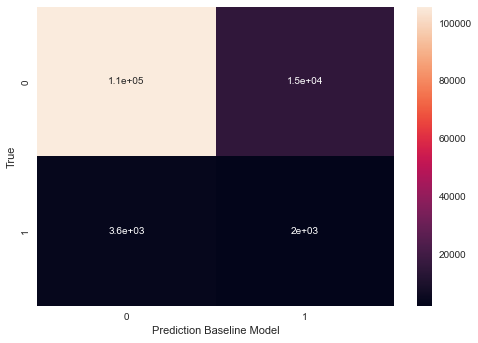

In [13]:
fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
auc_test = roc_auc_score(y_test, y_pred).round(2)
recall_test = recall_score(y_test, y_pred).round(2)
print("Test: f-2 score:", fbeta_test)
print("Test: Area under the ROC curve:", auc_test)
print("Test: Recall:", recall_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Prediction Baseline Model")
plt.ylabel("True");

An AUC of 0.60 and a recall of 0.22, there is definitely room for improvement with real models!

How are the predictions scattered over time?

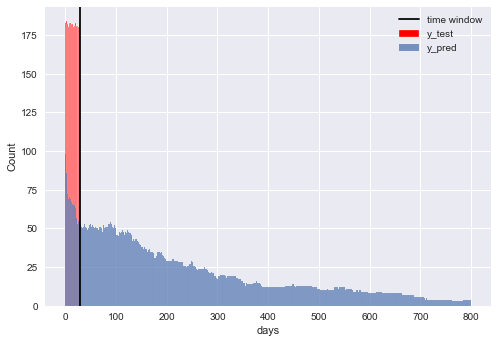

In [14]:
plotdata_pred = pd.DataFrame({"y": y_pred, "days": df_test.countdown}).query("y == 1")
plotdata_test = pd.DataFrame({"y": y_test, "days": df_test.countdown}).query("y == 1")
sns.histplot(data=plotdata_test, x="days", bins=time_window+1, color='r', alpha=1)
sns.histplot(data=plotdata_pred, x="days", bins=plotdata_pred.max().days)
plt.axvline(x=time_window, c='k')
plt.legend(["time window", "y_test", "y_pred"]);

We gradually classify HDDs as failing with substantial amount of HDDs classified around 100 and 50 days before failure. The day before failure we classify a lot of HDDs.

Plot ROC curve for understanding

We use probabilities of 0 or 1 since our baseline model cannot output probabilities. How does this influence the ROC curve? Will we obtain a straight line? Almost...

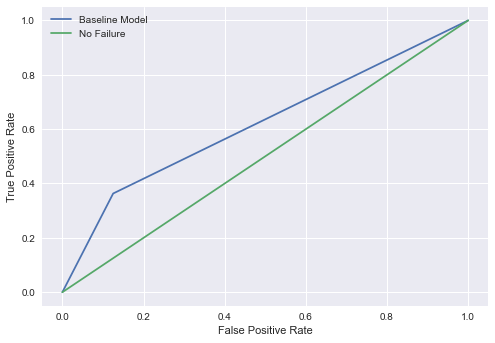

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr)
sns.lineplot(base, base)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

To sum up, our baseline model seems to be able to make an educated guess on our classification problem. Nevertheless, we are optimistic, that we can beat the baseline model in the course of this project.

## Logging on MLFlow

In [16]:
# #seting parameters that should be logged on MLFlow
# #these parameters were used in feature engineering (inputing missing values)
# #or parameters of the model (fit_intercept for Linear Regression model)
# params = {
#       "thresholds": threshold,
#       "time_to_fail": time_window,
#       "features_above_threshold": num_above_threshold,
#   }

In [17]:
# #logging params to mlflow
# mlflow.log_params(params)
# #setting tags
# mlflow.set_tag("running_from_jupyter", "True")
# mlflow.set_tag("model", "Baseline")
# mlflow.set_tag("Data", "2019-2021")
# #logging metrics
# mlflow.log_metric("train_" + "f-2 score", fbeta_train)
# mlflow.log_metric("test_" + "f-2 score", fbeta_test)
# # logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# # but possible if running mlflow locally
# # mlflow.log_artifact("../models")
# # mlflow.sklearn.log_model(reg, "model")
# mlflow.end_run()

In [18]:
# mlflow.get_run(run_id=run.info.run_id)

In [19]:
#!mlflow ui